In [1]:
import torch 
import numpy as np
import pandas as pd 
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
from torch.autograd import Variable

In [2]:
big_df = pd.read_csv('Apple_with_sentiment_onehot.csv')
big_df = big_df.drop(['High', 'Low', 'daily_return', 'majority_vote_score'], axis=1)
big_df['direction'] = np.where(big_df['Close'] - big_df['Open'] > 0, 1, -1)
big_df

,Date,Close,Open,Volume,direction,negative,neutral,positive
0,2004-01-02,0.319776,0.323833,144642400,-1,0,1,0
1,2004-01-05,0.333151,0.321880,395018400,1,1,0,0
2,2004-01-06,0.331948,0.334352,509348000,-1,1,0,0
3,2004-01-07,0.339462,0.332099,586874400,1,1,0,0
4,2004-01-08,0.351033,0.343219,460303200,1,1,0,0
...,...,...,...,...,...,...,...,...
5278,2024-12-23,254.655716,254.156919,40858800,1,1,0,0
5279,2024-12-24,257.578674,254.875189,23234700,1,1,0,0
5280,2024-12-26,258.396667,257.568678,27237100,1,1,0,0
5281,2024-12-27,254.974930,257.209530,42355300,-1,0,0,1


In [3]:
seq_len = 1
# start creating sequences only after the first seq_len elements have passed 
X = np.zeros((big_df.shape[0] - seq_len, 5))
y = np.zeros((big_df.shape[0] - seq_len, 1))
print("X shape :",X.shape)
print("y shape :",y.shape)

X shape : (5282, 5)
y shape : (5282, 1)


In [4]:
for i in range(seq_len , X.shape[0] + seq_len) :
    prev_elems = big_df.iloc[i-seq_len][['Open', 'Close', 'positive', 'negative', 'neutral']] # previous available date
    # only the desired values
    prev_elems = [ prev_elems[p] for p in range(len(prev_elems))]
    prev_elems = np.array(prev_elems)
    # Store previous day close price as feature 
    X[i-seq_len] = prev_elems
    # Store "today's" close price as label
    y[i-seq_len] = big_df.iloc[i]['Close']

In [5]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
#ss = StandardScaler()

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(np.array(y).reshape(-1, 1))

In [6]:
# fraction of the test set.
percentage = 0.30
split_tr = ceil(X_mm.shape[0] *(1-percentage))
split_val = ceil(X_mm.shape[0] *(1- percentage/2))

X_train = X_mm[0:split_tr]
y_train = y_mm[0:split_tr]
X_val= X_mm[split_tr: split_val]
y_val= y_mm[split_tr: split_val]
X_test= X_mm[split_val:]
y_test= y_mm[split_val:]
print(f"Train data shapes X:{X_train.shape} , y:{y_train.shape}")
print(f"Test data shapes X:{X_test.shape} , y:{y_test.shape}")
print(f"Val data shapes X:{X_val.shape} , y:{y_val.shape}")

Train data shapes X:(3698, 5) , y:(3698, 1)
Test data shapes X:(792, 5) , y:(792, 1)
Val data shapes X:(792, 5) , y:(792, 1)


In [7]:
X_tensors = Variable(torch.Tensor(X_mm))
y_tensors = Variable(torch.Tensor(y_mm))
#reshaping to rows, timestamps, features
X_tensors = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))
y_tensors = torch.reshape(y_tensors,  (y_tensors.shape[0], 1, y_tensors.shape[1]))


In [8]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
X_val_tensors = Variable(torch.Tensor(X_val))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
y_val_tensors = Variable(torch.Tensor(y_val))

In [9]:
#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
X_val_tensors_final = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)
print("Testing Shape", X_val_tensors_final.shape, y_val_tensors.shape)

Training Shape torch.Size([3698, 1, 5]) torch.Size([3698, 1])
Testing Shape torch.Size([792, 1, 5]) torch.Size([792, 1])
Testing Shape torch.Size([792, 1, 5]) torch.Size([792, 1])


In [10]:
class LSTM_reg(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size = 128):
        super(LSTM_reg, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size * num_layers, fc_size) #fully connected 1
        self.fc = nn.Linear(fc_size, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state 1st lstm layer
        c_0_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state 1st lstm layer

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0_0, c_0_0)) #lstm with input, hidden, and internal state
       # print(output.shape)
       # print(hn.shape)
        hn = hn.view(-1, self.hidden_size * num_layers) #reshaping (flatten) the data for Dense layer next
       # print(hn.shape)
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out

In [11]:
#hyperparameters
num_epochs = 1500 #1000 epochs
learning_rate = 0.0003 #0.001 lr

input_size = 5 #number of features
hidden_size = 60 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

lstm_reg = LSTM_reg(num_classes, input_size, hidden_size, num_layers, dropout=0.3, fc_size=310) #our lstm class

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_reg.parameters(), lr=learning_rate)

c:\Users\umuro\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [12]:
plot_loss_tr = []
plot_loss_val = []
for epoch in tqdm(range(num_epochs)):
    outputs = lstm_reg.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
    plot_loss_tr.append(loss.item())
    loss.backward() #calculates the loss of the loss function

    # Compute validation loss
    val_outs = lstm_reg.forward(X_val_tensors_final) #forward pass
    val_loss = criterion(val_outs, y_val_tensors)
    plot_loss_val.append(val_loss.item())

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, train_loss: %1.5f,  val_loss: %1.5f " % (epoch, loss.item(), val_loss.item()))

  0%|          | 7/1500 [00:02<05:42,  4.36it/s]

Epoch: 0, train_loss: 0.00314,  val_loss: 0.11463 


  7%|▋         | 107/1500 [00:03<00:22, 62.68it/s]

Epoch: 100, train_loss: 0.00178,  val_loss: 0.07795 


 14%|█▎        | 205/1500 [00:07<01:03, 20.45it/s]

Epoch: 200, train_loss: 0.00009,  val_loss: 0.01130 


 20%|██        | 304/1500 [00:11<00:54, 21.96it/s]

Epoch: 300, train_loss: 0.00000,  val_loss: 0.00298 


 27%|██▋       | 402/1500 [00:14<00:41, 26.69it/s]

Epoch: 400, train_loss: 0.00000,  val_loss: 0.00281 


 34%|███▍      | 508/1500 [00:17<00:18, 53.26it/s]

Epoch: 500, train_loss: 0.00000,  val_loss: 0.00281 


 41%|████      | 613/1500 [00:18<00:12, 69.49it/s]

Epoch: 600, train_loss: 0.00000,  val_loss: 0.00279 


 47%|████▋     | 702/1500 [00:20<00:36, 21.84it/s]

Epoch: 700, train_loss: 0.00000,  val_loss: 0.00278 


 54%|█████▎    | 806/1500 [00:27<00:17, 39.10it/s]

Epoch: 800, train_loss: 0.00000,  val_loss: 0.00278 


 60%|██████    | 905/1500 [00:34<00:24, 24.26it/s]

Epoch: 900, train_loss: 0.00000,  val_loss: 0.00278 


 67%|██████▋   | 1010/1500 [00:36<00:10, 48.40it/s]

Epoch: 1000, train_loss: 0.00000,  val_loss: 0.00278 


 74%|███████▍  | 1107/1500 [00:38<00:05, 65.92it/s]

Epoch: 1100, train_loss: 0.00000,  val_loss: 0.00278 


 81%|████████  | 1212/1500 [00:39<00:03, 74.99it/s]

Epoch: 1200, train_loss: 0.00000,  val_loss: 0.00277 


 88%|████████▊ | 1314/1500 [00:40<00:02, 69.71it/s]

Epoch: 1300, train_loss: 0.00000,  val_loss: 0.00277 


 94%|█████████▍| 1408/1500 [00:42<00:01, 73.57it/s]

Epoch: 1400, train_loss: 0.00000,  val_loss: 0.00277 


100%|██████████| 1500/1500 [00:43<00:00, 34.21it/s]


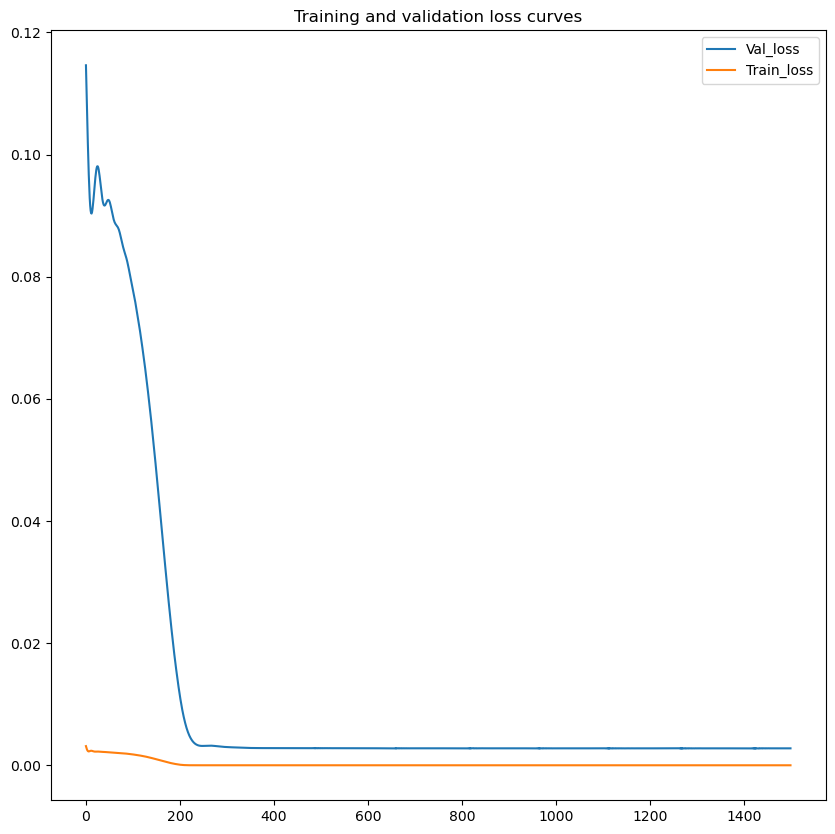

In [13]:
fig , ax = plt.subplots(figsize = (10,10))

plt.plot(plot_loss_val, label='Val_loss') #actual plot
plt.plot(plot_loss_tr, label='Train_loss') #predicted plot
plt.title('Training and validation loss curves')
plt.legend()
plt.show()

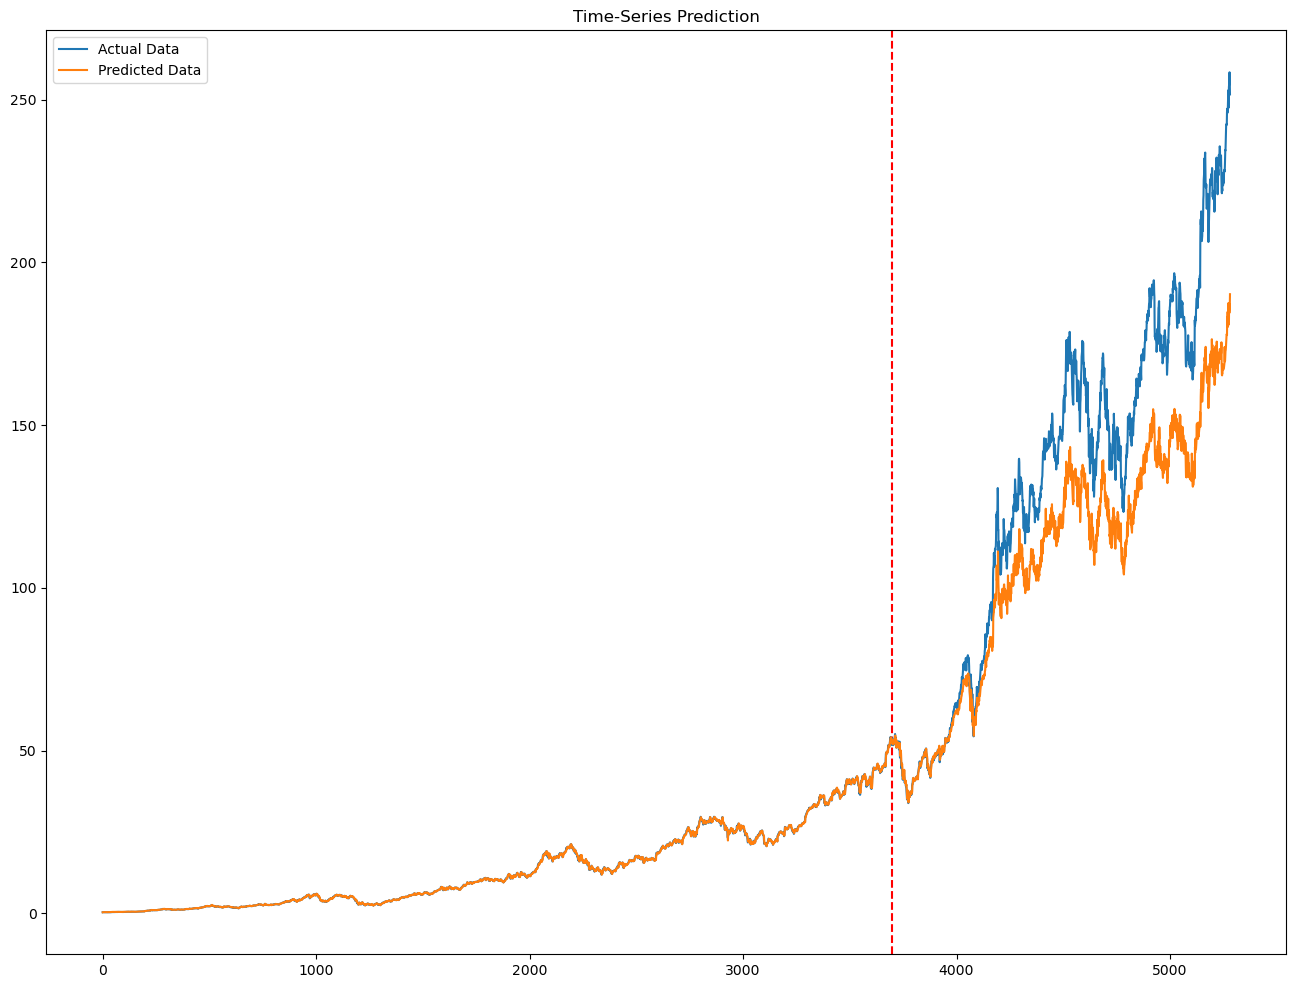

In [14]:
train_predict = lstm_reg(X_tensors) #forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y_tensors.data.numpy()
dataY_plot =  np.reshape(dataY_plot, (dataY_plot.shape[0],1))

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(16,12)) #plotting
plt.axvline(x=split_tr, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [15]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_tr : split_val] - data_predict[split_tr : split_val], 2).mean())
print("VAL DATA, MSE loss : ", mse)

VAL DATA, MSE loss :  184.87653


In [16]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[:split_tr] - data_predict[:split_tr], 2).mean())
print("TRAIN DATA , MSE loss : ", mse)

TRAIN DATA , MSE loss :  0.08158572


In [17]:
from scipy.stats import spearmanr, pearsonr
#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[split_tr : split_val], data_predict[split_tr : split_val])
print("Val DATA,  Spreaman correlation : ", spearman)
pearson, p= pearsonr(np.squeeze(dataY_plot[split_tr : split_val]), np.squeeze(data_predict[split_tr : split_val]))
print("VAL DATA,  Pearson correlation=", pearson, ", pvalue=",p)


#from sklearn.metric import mean_squared_error
spearman = spearmanr(dataY_plot[:split_tr],data_predict[:split_tr])
print("TRAIN DATA , Spreaman correlation : ", spearman)
pearson2, p2= pearsonr(np.squeeze(dataY_plot[:split_tr]), np.squeeze(data_predict[:split_tr]))
print("TRAIN DATA,  Pearson correlation=", pearson2, ", pvalue=",p2)

Val DATA,  Spreaman correlation :  SignificanceResult(statistic=0.9963825947609685, pvalue=0.0)
VAL DATA,  Pearson correlation= 0.9968214916133239 , pvalue= 0.0
TRAIN DATA , Spreaman correlation :  SignificanceResult(statistic=0.9997221081314122, pvalue=0.0)
TRAIN DATA,  Pearson correlation= 0.9997331607909843 , pvalue= 0.0


In [18]:
#from sklearn.metric import mean_squared_error
mse = (np.power(dataY_plot[split_val:] - data_predict[split_val:], 2).mean())
print("TEST DATA, MSE loss : ", mse)

spearman = spearmanr(dataY_plot[split_val:],data_predict[split_val:])
print("TEST DATA,  Spreaman correlation : ", spearman)
pearson, p= pearsonr(np.squeeze(dataY_plot[split_val : ]), np.squeeze(data_predict[split_val : ]))
print("TEST DATA,  Pearson correlation=", pearson, ", pvalue=",p)

TEST DATA, MSE loss :  1509.4486
TEST DATA,  Spreaman correlation :  SignificanceResult(statistic=0.9848635625792768, pvalue=0.0)
TEST DATA,  Pearson correlation= 0.9880725312483933 , pvalue= 0.0
